In [1]:
!pip install Pillow --quiet
!pip install webdataset==0.1.62
!pip install pytorch-model-summary

  Attempting uninstall: webdataset
    Found existing installation: webdataset 0.1.103
    Uninstalling webdataset-0.1.103:
      Successfully uninstalled webdataset-0.1.103


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.models as models
import torchvision.transforms as T
import numpy as np
import h5py
import os
import sys
import datetime
import csv
import pickle

import torchvision
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import logging
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset

# For visualize input
from torch.utils.tensorboard import SummaryWriter
import io
import torchvision
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from PIL import Image

In [2]:
import webdataset as wds
from itertools import islice
import struct, ast
from importlib_metadata import version

In [3]:
def plot_raw_EEG(data, n_sample):
    numChan = 24
    if len(data[0]) == 2: # torch batch
        x_data = data[:][0]
    else:
        x_data = data
    row = col = int(np.sqrt(n_sample))
    fig = plt.figure(figsize=(row*10, col*10))
    outer = gridspec.GridSpec(row, col)
    print(n_sample)
    for i in range(n_sample):
        inner = gridspec.GridSpecFromSubplotSpec(numChan, 1,
                        subplot_spec=outer[i])
#             npimg = img[i,:,:,:].numpy()
        npimg = x_data[i,:,:,:]
        npimg = np.reshape(npimg,(numChan,256))
        yax = None
        for j in range(numChan):
            ax = plt.Subplot(fig, inner[j])
            ax.plot(range(256),npimg[j,:],'k')
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)

    return fig

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [4]:
def load_data(path, role, winLength, numChan, srate, feature, one_channel=False, version=""):
    """
    Load dataset
    :param  
        path: Filepath to the dataset
        role: Role of the dataset. Can be "train", "val", or "test"
        winLength: Length of time window. Can be 2 or 15
        numChan: Number of channels. Can be 24 or 128
        srate: Sampling rate. Supporting 126Hz
        feature: Input feature. Can be "raw", "spectral", or "topo"
        one_channel: Where input has 1 or 3 channel in depth dimension. Matters when load topo data as number of input channels 
                are different from original's
        version: Any additional information of the datafile. Will be appended to the file name at the end
    """
    transform = T.Compose([
        T.ToTensor()
    ])
    if version:
        f = h5py.File(path + f"child_mind_x_{role}_{winLength}s_{numChan}chan_{feature}_{version}.mat", 'r')
    else:
        f = h5py.File(path + f"child_mind_x_{role}_{winLength}s_{numChan}chan_{feature}.mat", 'r')
    x = f[f'X_{role}']
    clean_idx = []
    if feature == 'raw':
        x = np.transpose(x,(0,2,1))
        x = np.reshape(x,(-1,1,numChan,winLength*srate))
        clean_x_idx = []
        for i in range(x.shape[0]):
            sample = x[i,:,:,:]
            if np.max(sample) < 5000 and np.min(sample) > -5000:
                clean_x_idx.append(i)
        print("clean sample amplitude threshold:",len(clean_x_idx))
        
        clean_subj_idx = []
        for i in range(0,x.shape[0],81):
#             print("i:",i)
            subj_data = x[i:i+80,:,:,:]
            
            mean_mat = np.mean(subj_data)
            std_mat = np.std(subj_data)
            
            subj_data = (subj_data - mean_mat)/std_mat
#             print(f"sanity check - mean before {mean_mat}, after {np.mean(subj_data)}")
#             print(f"sanity check - var before {var_mat}, after {np.var(subj_data)}")
            
#             x[i:i+80,:,:,:] = subj_data
            
            subj_std = np.std(subj_data)
#             print("subject max:", np.max(subj_data.flatten()))
#             print("subject std:",subj_std)
            if subj_std < 5:
                clean_subj_idx.extend(list(range(i,i+80)))
        print("clean sample std<5:",len(clean_subj_idx))
        
        clean_transient = []
        for i in range(x.shape[0]):
            sample = x[i,:,:,:]
            transient = np.diff(sample, axis=2)
            assert(transient.shape == (1,24,255))
            transient_std = np.std(transient)
            if transient_std < 3:
                clean_transient.append(i)
        print("clean transient std<3:",len(clean_transient))
        
        clean_idx = intersection(clean_x_idx, clean_subj_idx)
        clean_idx = intersection(clean_idx, clean_transient)
        print("num of clean trials:", len(clean_idx))
        
        # min max scaling
        for i in range(0,x.shape[0],81):
            subj_data = x[i:i+80,:,:,:]
            
            subj_min = np.min(subj_data)
            subj_max = np.max(subj_data)
            
            subj_data = (subj_data - subj_min)/(subj_max-subj_min)
            x[i:i+80,:,:,:] = subj_data
        clean_idx = sorted(clean_idx)
        x = x[clean_idx,:,:,:]
#         x = x[:2000,:,:,:]
    elif feature == 'topo':
        if one_channel:
            samples = []
            for i in range(x.shape[0]):
                image = x[i]
                b, g, r = image[0,:, :], image[1,:, :], image[2,:, :]
                concat = np.concatenate((b,g,r), axis=1)
                samples.append(concat)
            x = np.stack(samples)
            x = np.reshape(x,(-1,1,x.shape[1],x.shape[2]))
    
    if version:
        f = h5py.File(path + f"child_mind_y_{role}_{winLength}s_{numChan}chan_{feature}_{version}.mat", 'r')
    else:
        f = h5py.File(path + f"child_mind_y_{role}_{winLength}s_{numChan}chan_{feature}.mat", 'r')
    y = f[f'Y_{role}']
#     print(clean_idx)
    y = y[clean_idx]
#     y = y[:2000]
    return EEGDataset(x, y, role=='train', role=='val'), x, y

class EEGDataset(Dataset):
    def __init__(self, x, y, train, val):
        super(EEGDataset).__init__()
        assert x.shape[0] == y.size
        self.x = x
        self.y = [y[i][0] for i in range(y.size)]
        self.train = train
        self.val = val

    def __getitem__(self,key):
        return (self.x[key], self.y[key])

    def __len__(self):
        return len(self.y)

In [5]:
path = './data/'
winLength = 2
numChan = 24
srate = 128
feature = 'raw'
one_channel = False

role = 'train'
train_data, X_train, Y_train = load_data(path, role, winLength, numChan, srate, feature, one_channel)
print(f'X_train shape: {len(train_data)}, {train_data[0][0].shape}')
print(f'Y_train shape: {len(train_data)}, {train_data[0][1].shape}')
# val_data, X_val, Y_val = load_data(path, 'val', winLength, numChan, srate, feature, one_channel)
# print(f'X_val shape: {len(val_data)}, {val_data[0][0].shape}')
# print(f'Y_val shape: {len(val_data)}, {val_data[0][1].shape}')

clean sample amplitude threshold: 70942


/home/dtyoung/.conda/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


clean sample std<5: 70320
clean transient std<3: 21218
num of clean trials: 20723


/home/dtyoung/.conda/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide


X_train shape: 20723, (1, 24, 256)
Y_train shape: 20723, ()


4


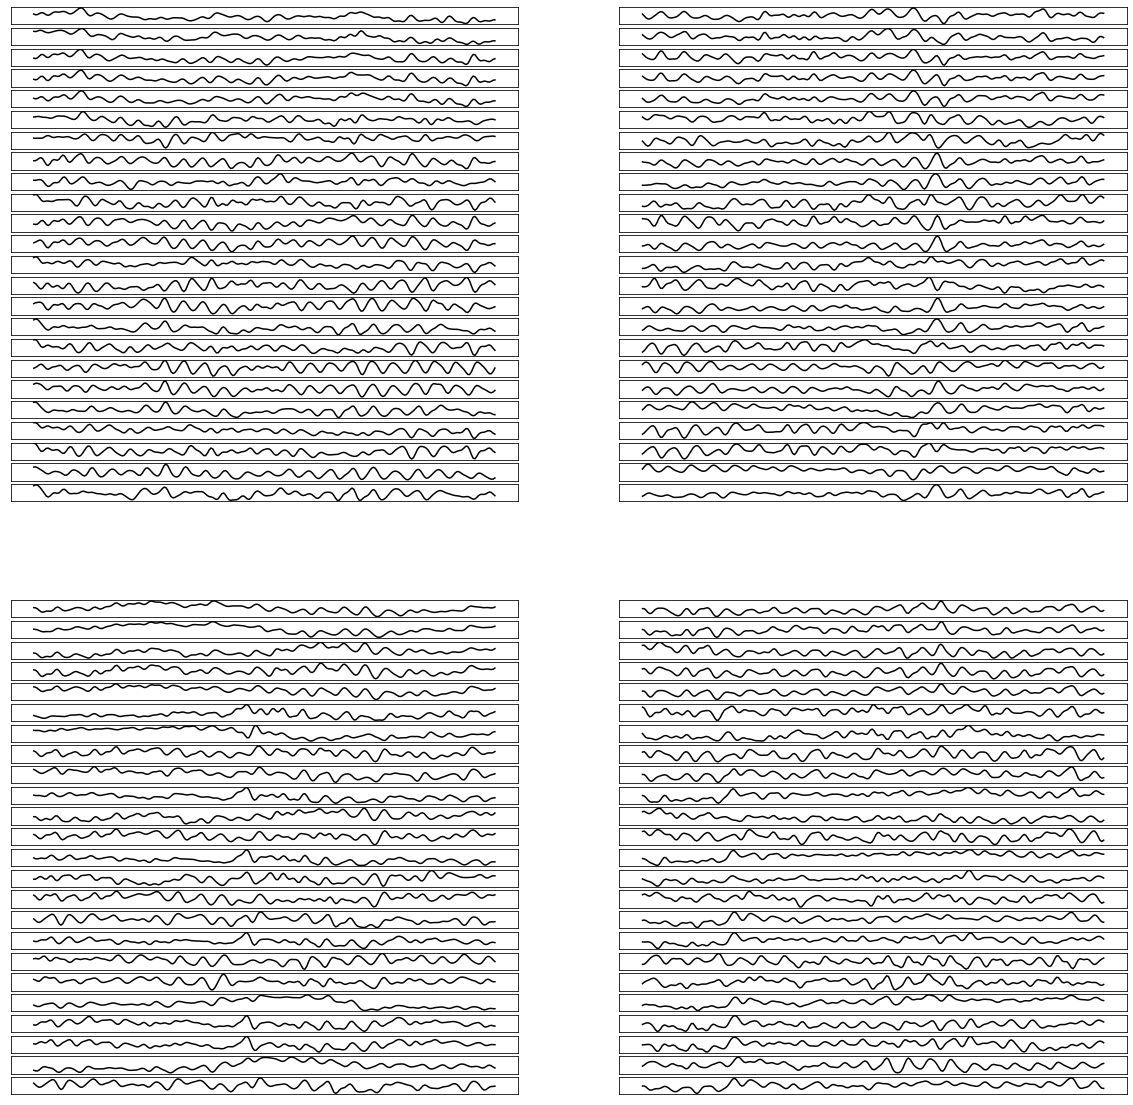

In [6]:
fig = plot_raw_EEG(train_data, 4)

In [6]:
class Logger():
    def __init__(self, mode='log'):
        self.mode = mode
        
    def set_model_save_location(self, model_dir):
        self.model_dir = f"saved-model/{model_dir}"
        
    def set_experiment(self, experiment_name):
        self.experiment_name = experiment_name
        log_format = '%(asctime)s %(message)s'
        logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                            format=log_format, datefmt='%m/%d %I:%M:%S %p')
        fh = logging.FileHandler(os.path.join('training-logs', f'log-{experiment_name}-{datetime.datetime.today()}.txt'))
        fh.setFormatter(logging.Formatter(log_format))
        logging.getLogger().addHandler(fh)
        self.writer = SummaryWriter(f"runs/{experiment_name}")
            
    def log(self, message=""):
        if self.mode == 'log':
            logging.info(message)
        elif self.mode == 'debug':
            print(message)

    def save_model(self, model, info):
        torch.save(model.state_dict(), f"{self.model_dir}/model-{self.experiment_name}-{info}")
        
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

isDebug = False

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

latent_dim = 10
print('latent dimension:', str(latent_dim))
def add_chan_dim(x):
    x = torch.tensor(x)
#     x = torch.transpose(x, 0, 1)
    return torch.unsqueeze(x,0)


def selectLabel(x,lbl):
    # # function to select desired label
    lbl_idx = ["id","sex","age","handedness","index"].index(lbl.lower())
    x = x.decode("utf-8").split(",")
    # return x if lbl_idx == 0 else float(x)
    return 1
    
# s3_url = 'https://childmind.s3.us-west-1.amazonaws.com/python/childmind_train.tar' # replace 'train' with 'val' and 'test' accordingly
# train_data = wds.WebDataset(s3_url).decode().map_dict(npy=add_chan_dim, cls=lambda x: selectLabel(x,'sex')).to_tuple("npy","cls")

# s3_url = 'https://childmind.s3.us-west-1.amazonaws.com/python/childmind_val.tar' # replace 'train' with 'val' and 'test' accordingly
# val_data = wds.WebDataset(s3_url).decode().map_dict(npy=add_chan_dim, cls=lambda x: selectLabel(x,'sex')).to_tuple("npy","cls")

using device: cuda
latent dimension: 10


In [7]:
class VAE(nn.Module): 
    
    def __init__(self, latent_dim):
        # latent_dim: dimension of the latent representation vector
        super().__init__()
        self.latent_dim = latent_dim
        self.beta = 4
        self.gamma = 1000.
        self.loss_type = 'H'
        self.C_max = torch.tensor([25])
        self.C_stop_iter = 1e5

        encoder_l = [self.encoder_conv_block(True)]
        for i in range(2):
            encoder_l.append(self.encoder_conv_block())
        encoder_l.append(self.encoder_conv_block(False, 5, 5, 3, 1, 0))
        encoder_l.append(nn.Flatten())
        self.encoder_before_last = nn.ModuleList(encoder_l)
        self.encoder_mu = self.encoder_linear_block(150, latent_dim) #960
        self.encoder_log_var = self.encoder_linear_block(150, latent_dim)
       
        self.autoencoder_linear = self.encoder_linear_block(150, latent_dim)
                            
        decoder_l = [self.decoder_linear_block(latent_dim, 150)]
        decoder_l.append(self.decoder_conv_block(False, 5, 5, 3, 1, 0))
        for i in range(2):
            decoder_l.append(self.decoder_conv_block())
        decoder_l.append(self.decoder_conv_block(True))
        self.decoder = nn.ModuleList(decoder_l)
    
    def encoder_conv_block(self, is_start=False, in_channels=5, out_channels=5, kernel_size=6, stride=2, padding=2):
        if is_start:
            return nn.Sequential(
                nn.Conv2d(1, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
    def encoder_linear_block(self, in_chan, out_chan):
        return nn.Sequential(
            nn.Linear(in_chan, out_chan),
            nn.ReLU()
        )
    
    def decoder_conv_block(self, is_last=False, in_channels=5, out_channels=5, kernel_size=6, stride=2, padding=2):
        if is_last:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, 1, kernel_size, stride, padding),
                nn.BatchNorm2d(1),
                nn.ReLU()
#                 nn.Sigmoid()
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
    
    def decoder_linear_block(self, in_chan, out_chan):
        return nn.Sequential(
            nn.Linear(in_chan, out_chan),
            nn.ReLU()
        )
    
    def forward(self, x):
        for f in self.encoder_before_last:
            x = f(x)
        mu = self.encoder_mu(x)
        log_var = self.encoder_log_var(x)
        z = self.reparameterize(mu, log_var)
        
#         z = self.autoencoder_linear(x)
        x = self.decode(z)
            
        return x, mu, log_var
    
    def encode(self,x):
        for f in self.encoder_before_last:
            x = f(x)
        mu = self.encoder_mu(x)
        log_var = self.encoder_log_var(x)
        z = self.reparameterize(mu, log_var)
        return z
    
    def decode(self, z):
        x = self.decoder[0](z)
        x = x.view(-1, 5, 1, 30) # reshape the tensor to be expected dimension for ConvTranspose
        for i in range(1,len(self.decoder)):
            f = self.decoder[i]
            x = f(x) 
        return x
    
    def generate_sample(self, n_sample):
        z = torch.randn((n_sample, self.latent_dim))
        return self.decode(z)
    
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
#         print("log_var:", log_var)
#         print('mu:', mu)
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample

    def sample_z(self, mu, sigma):
        # Input
        #     mu:     [batch_size, self.latent_size] the predicted mu value for each sample in the batch
        #     sigma:  [batch_size, self.latent_size] the predicted diag elem of sigma value for each sample in the batch
        # Output
        #     z: [batch_size, self.latent_size] the latent representation of each sample in the batch
        # Reference: https://agustinus.kristia.de/techblog/2016/12/10/variational-autoencoder/
        
        # eps ~ N(0,1)        
        batch_size = mu.size()[0]
        eps = torch.randn((batch_size,1), device=device, dtype=dtype)
        z = mu + sigma/2*eps
        
        return z

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        recons = args[0]
        ori = args[1]
        mu = args[2]
        log_var = args[3]
        kld_weight = kwargs['M_N']  # Account for the minibatch samples from the dataset

        recons_loss = F.mse_loss(recons, ori) #F.binary_cross_entropy(recons, ori) #

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0) # is it - log_var?
        # -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

        if self.loss_type == 'H': # https://openreview.net/forum?id=Sy2fzU9gl
            loss = recons_loss + self.beta * kld_weight * kld_loss
        elif self.loss_type == 'B': # https://arxiv.org/pdf/1804.03599.pdf
            self.C_max = self.C_max.to(input.device)
            C = torch.clamp(self.C_max/self.C_stop_iter * self.num_iter, 0, self.C_max.data[0])
            loss = recons_loss + self.gamma * kld_weight* (kld_loss - C).abs()
        else:
            raise ValueError('Undefined loss type.')

        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':kld_loss}

In [8]:
class ToCorrectSizeTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        correct_size_sample = torch.zeros(1,24,256)
        correct_size_sample[0,:,0:28] = sample[0,2:26,:]
        return correct_size_sample

vae = VAE(latent_dim)
vae = vae.to(device=device)

if isDebug:
    mnist_train = torchvision.datasets.MNIST('./mnist', train=True, download=True, transform = transforms.Compose([transforms.ToTensor(),ToCorrectSizeTensor()]))
    mnist_test = torchvision.datasets.MNIST('./mnist', train=False, download=True, transform = transforms.Compose([transforms.ToTensor(), ToCorrectSizeTensor()]))
    sample = torch.unsqueeze(mnist_train[0][0],0)
    sample = sample.to(device=device)
else:
    sample = torch.zeros((1, 1, 24, 256), device=device)
# print(vae)                         
from pytorch_model_summary import summary
# print(summary(vae, sample, show_input=False)) 
print(summary(vae, sample, show_input=False))

--------------------------------------------------------------------------
         Layer (type)        Output Shape         Param #     Tr. Param #
             Conv2d-1     [1, 5, 12, 128]             185             185
        BatchNorm2d-2     [1, 5, 12, 128]              10              10
               ReLU-3     [1, 5, 12, 128]               0               0
             Conv2d-4       [1, 5, 6, 64]             905             905
        BatchNorm2d-5       [1, 5, 6, 64]              10              10
               ReLU-6       [1, 5, 6, 64]               0               0
             Conv2d-7       [1, 5, 3, 32]             905             905
        BatchNorm2d-8       [1, 5, 3, 32]              10              10
               ReLU-9       [1, 5, 3, 32]               0               0
            Conv2d-10       [1, 5, 1, 30]             230             230
       BatchNorm2d-11       [1, 5, 1, 30]              10              10
              ReLU-12       [1, 5, 1,

KL divergence loss
![kl_loss](https://github.com/dungscout96/deep-representation-learning-EEG/blob/master/images/kl_loss.png?raw=1)

In [9]:
def plot_losses(losses):
    plt.plot(losses['total'])
    plt.figure()
    plt.plot(losses['recons'])
    plt.figure()
    plt.plot(losses['kld'])
    
def plot_norms():
    plt.figure()
    # plt.plot(weight_norm['decoder'], label="decoder")
    # plt.plot(weight_norm['encoder_before_last'], label="encoder b4 last")
    plt.plot(weight_norm['encoder_mu'], label="encoder mu")
    plt.plot(weight_norm['encoder_log_var'], label="encoder log var")
    plt.legend()

In [30]:
experiment = 'experiment/HBN/autoencoder/spectra/epochs20-29'

In [31]:
def load_experiment(experiment_path):
    trained_model = VAE(latent_dim)
    trained_model.load_state_dict(torch.load(f'{experiment_path}/model'))
    file = open(f"{experiment_path}/params.pkl",'rb')
    params = pickle.load(file)
    
    file = open(f"{experiment_path}/losses.pkl",'rb')
    losses = pickle.load(file)
    return trained_model, params, losses

trained_model, params, losses = load_experiment(experiment)
print("experiment params:", params)
print(losses.keys())

experiment params: {'isDebug': False, 'batch_size': 128, 'M_N': 1, 'epoch': 10, 'lr': 0.001, 'seed': 0, 'beta': 0, 'isAutoencoder': True, 'amplitude_clean': True, 'std_threshold': True, 'transient_threshold': True, 'min_max_norm': True, 'num_sam': 20723}
dict_keys(['total', 'recons', 'kld'])


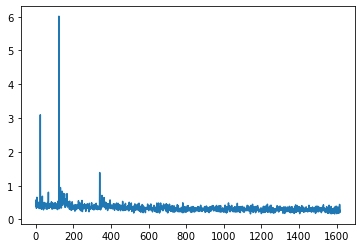

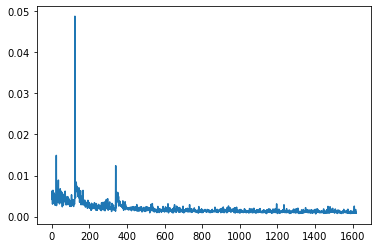

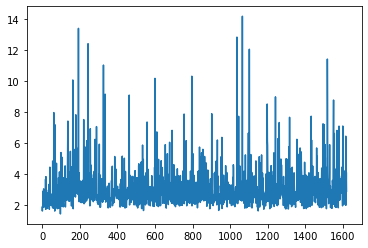

In [32]:
plot_losses(losses)

16
16


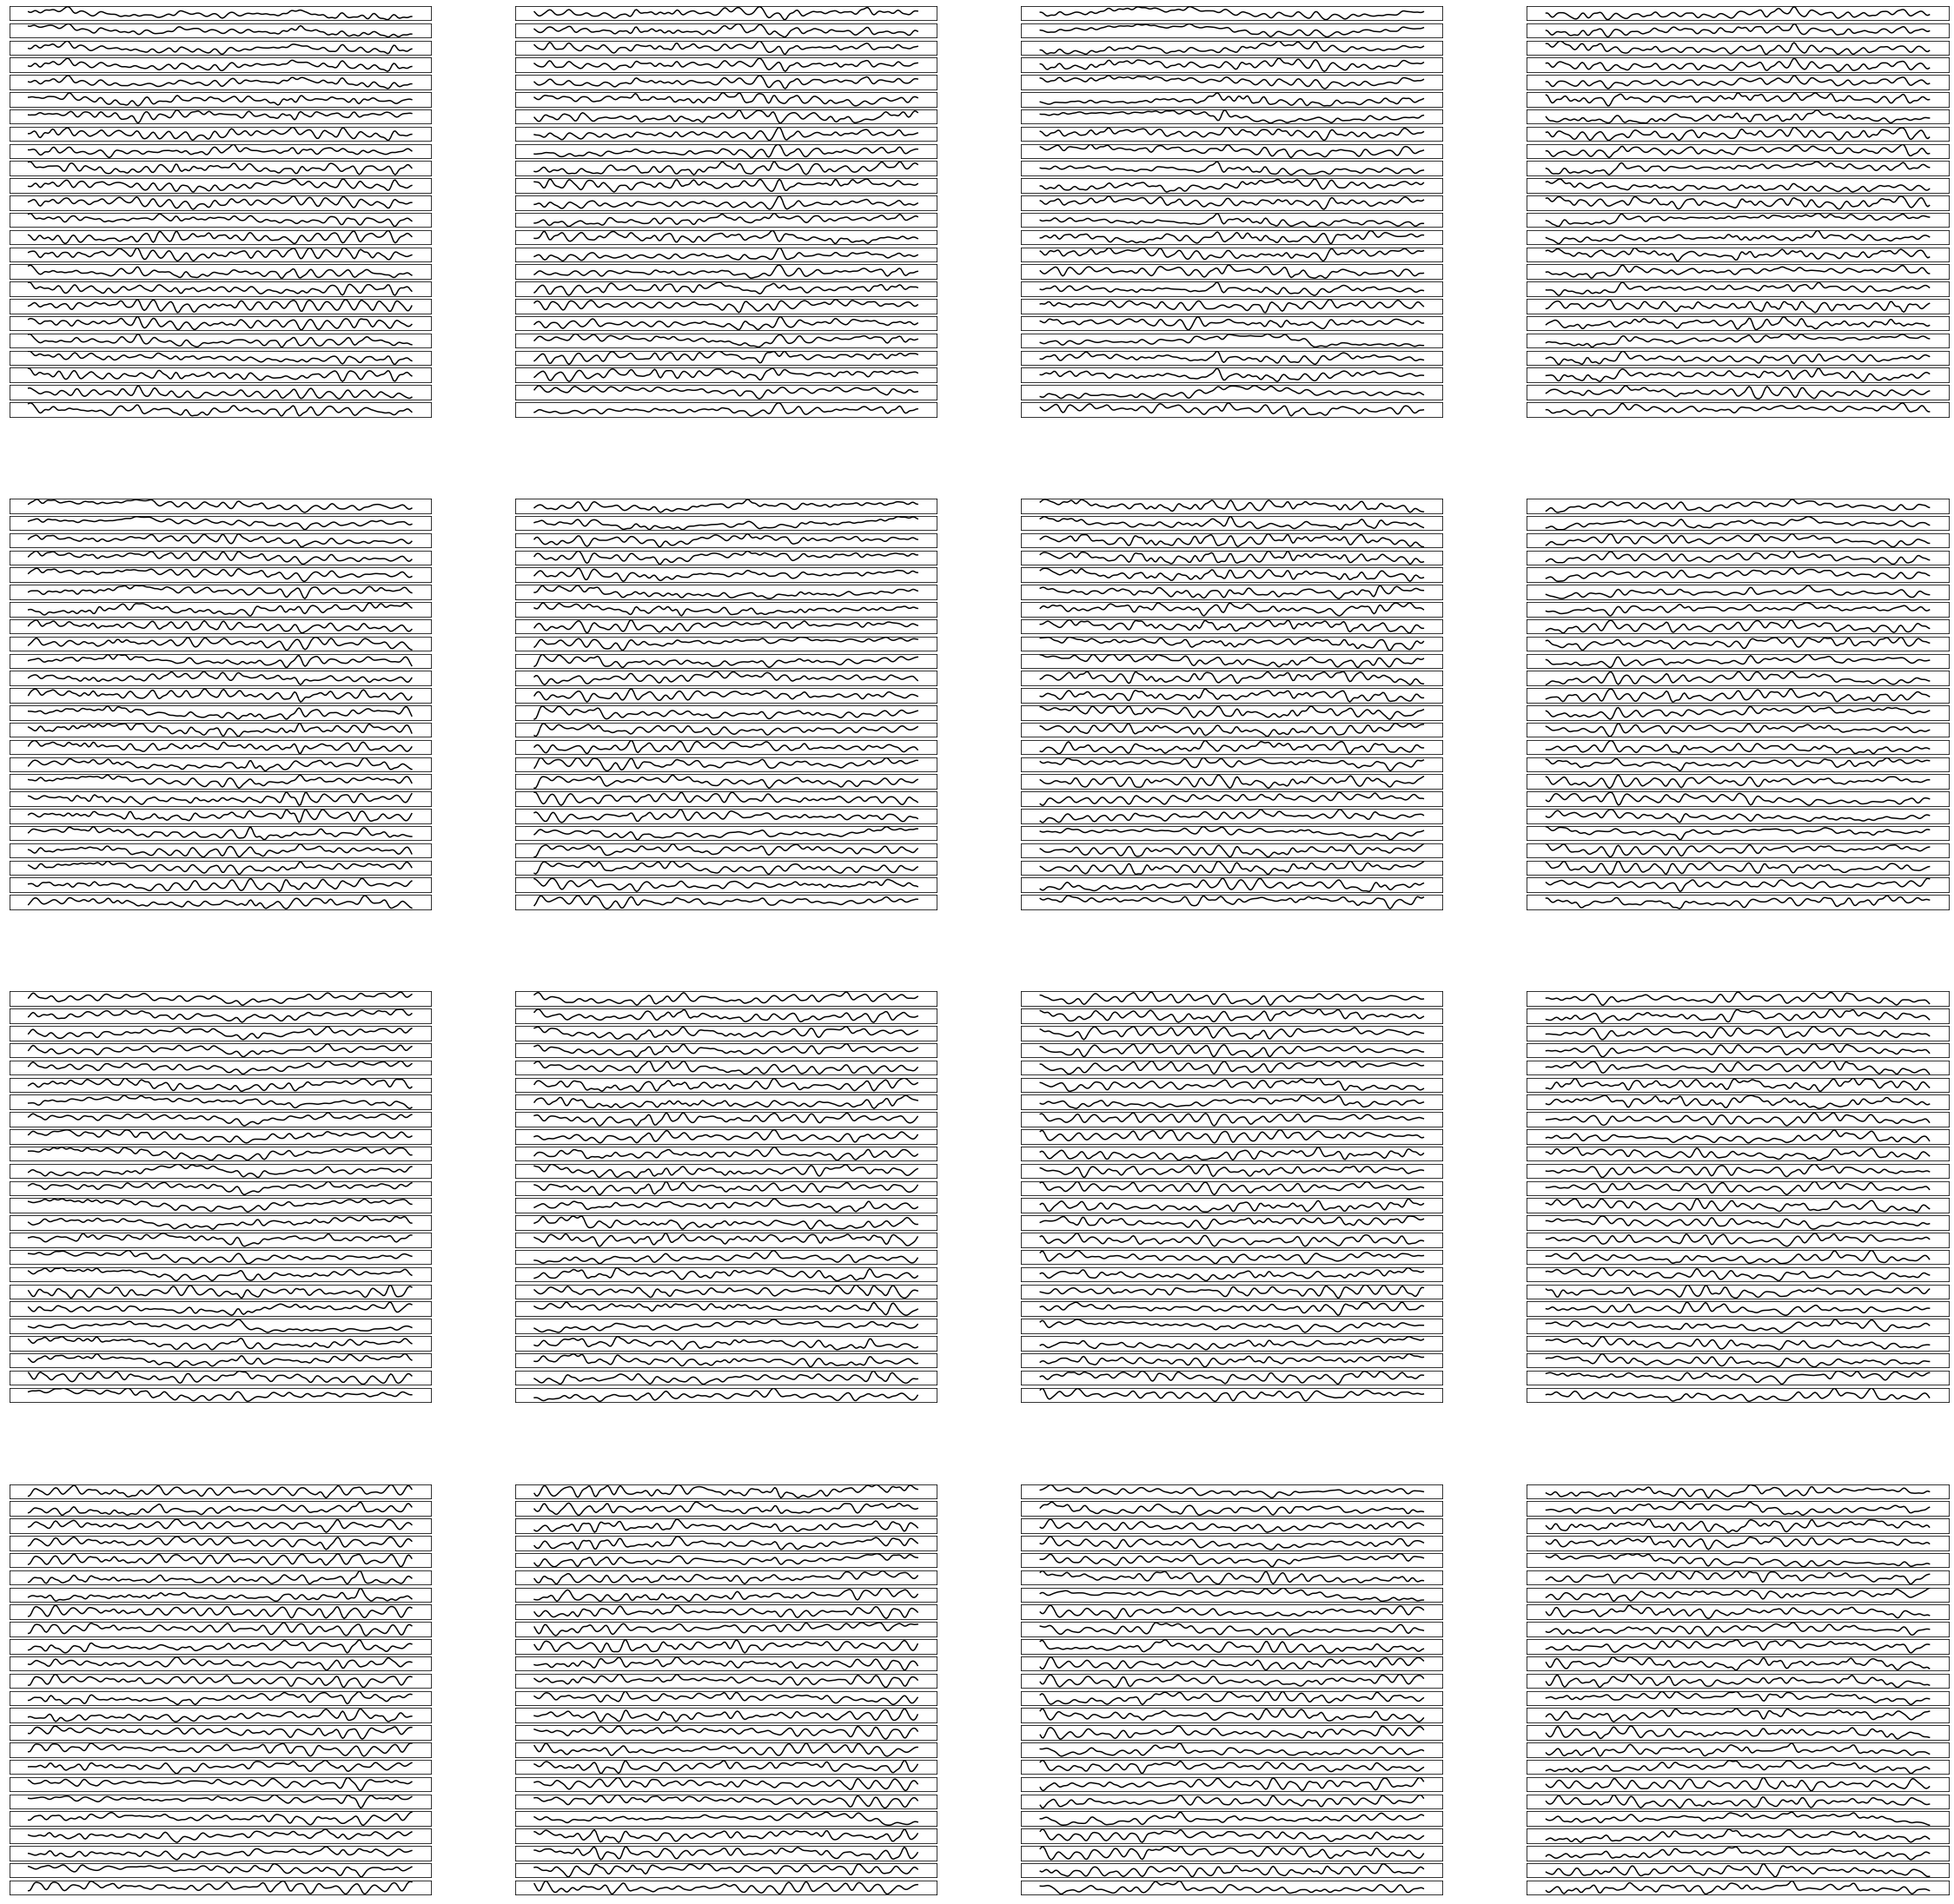

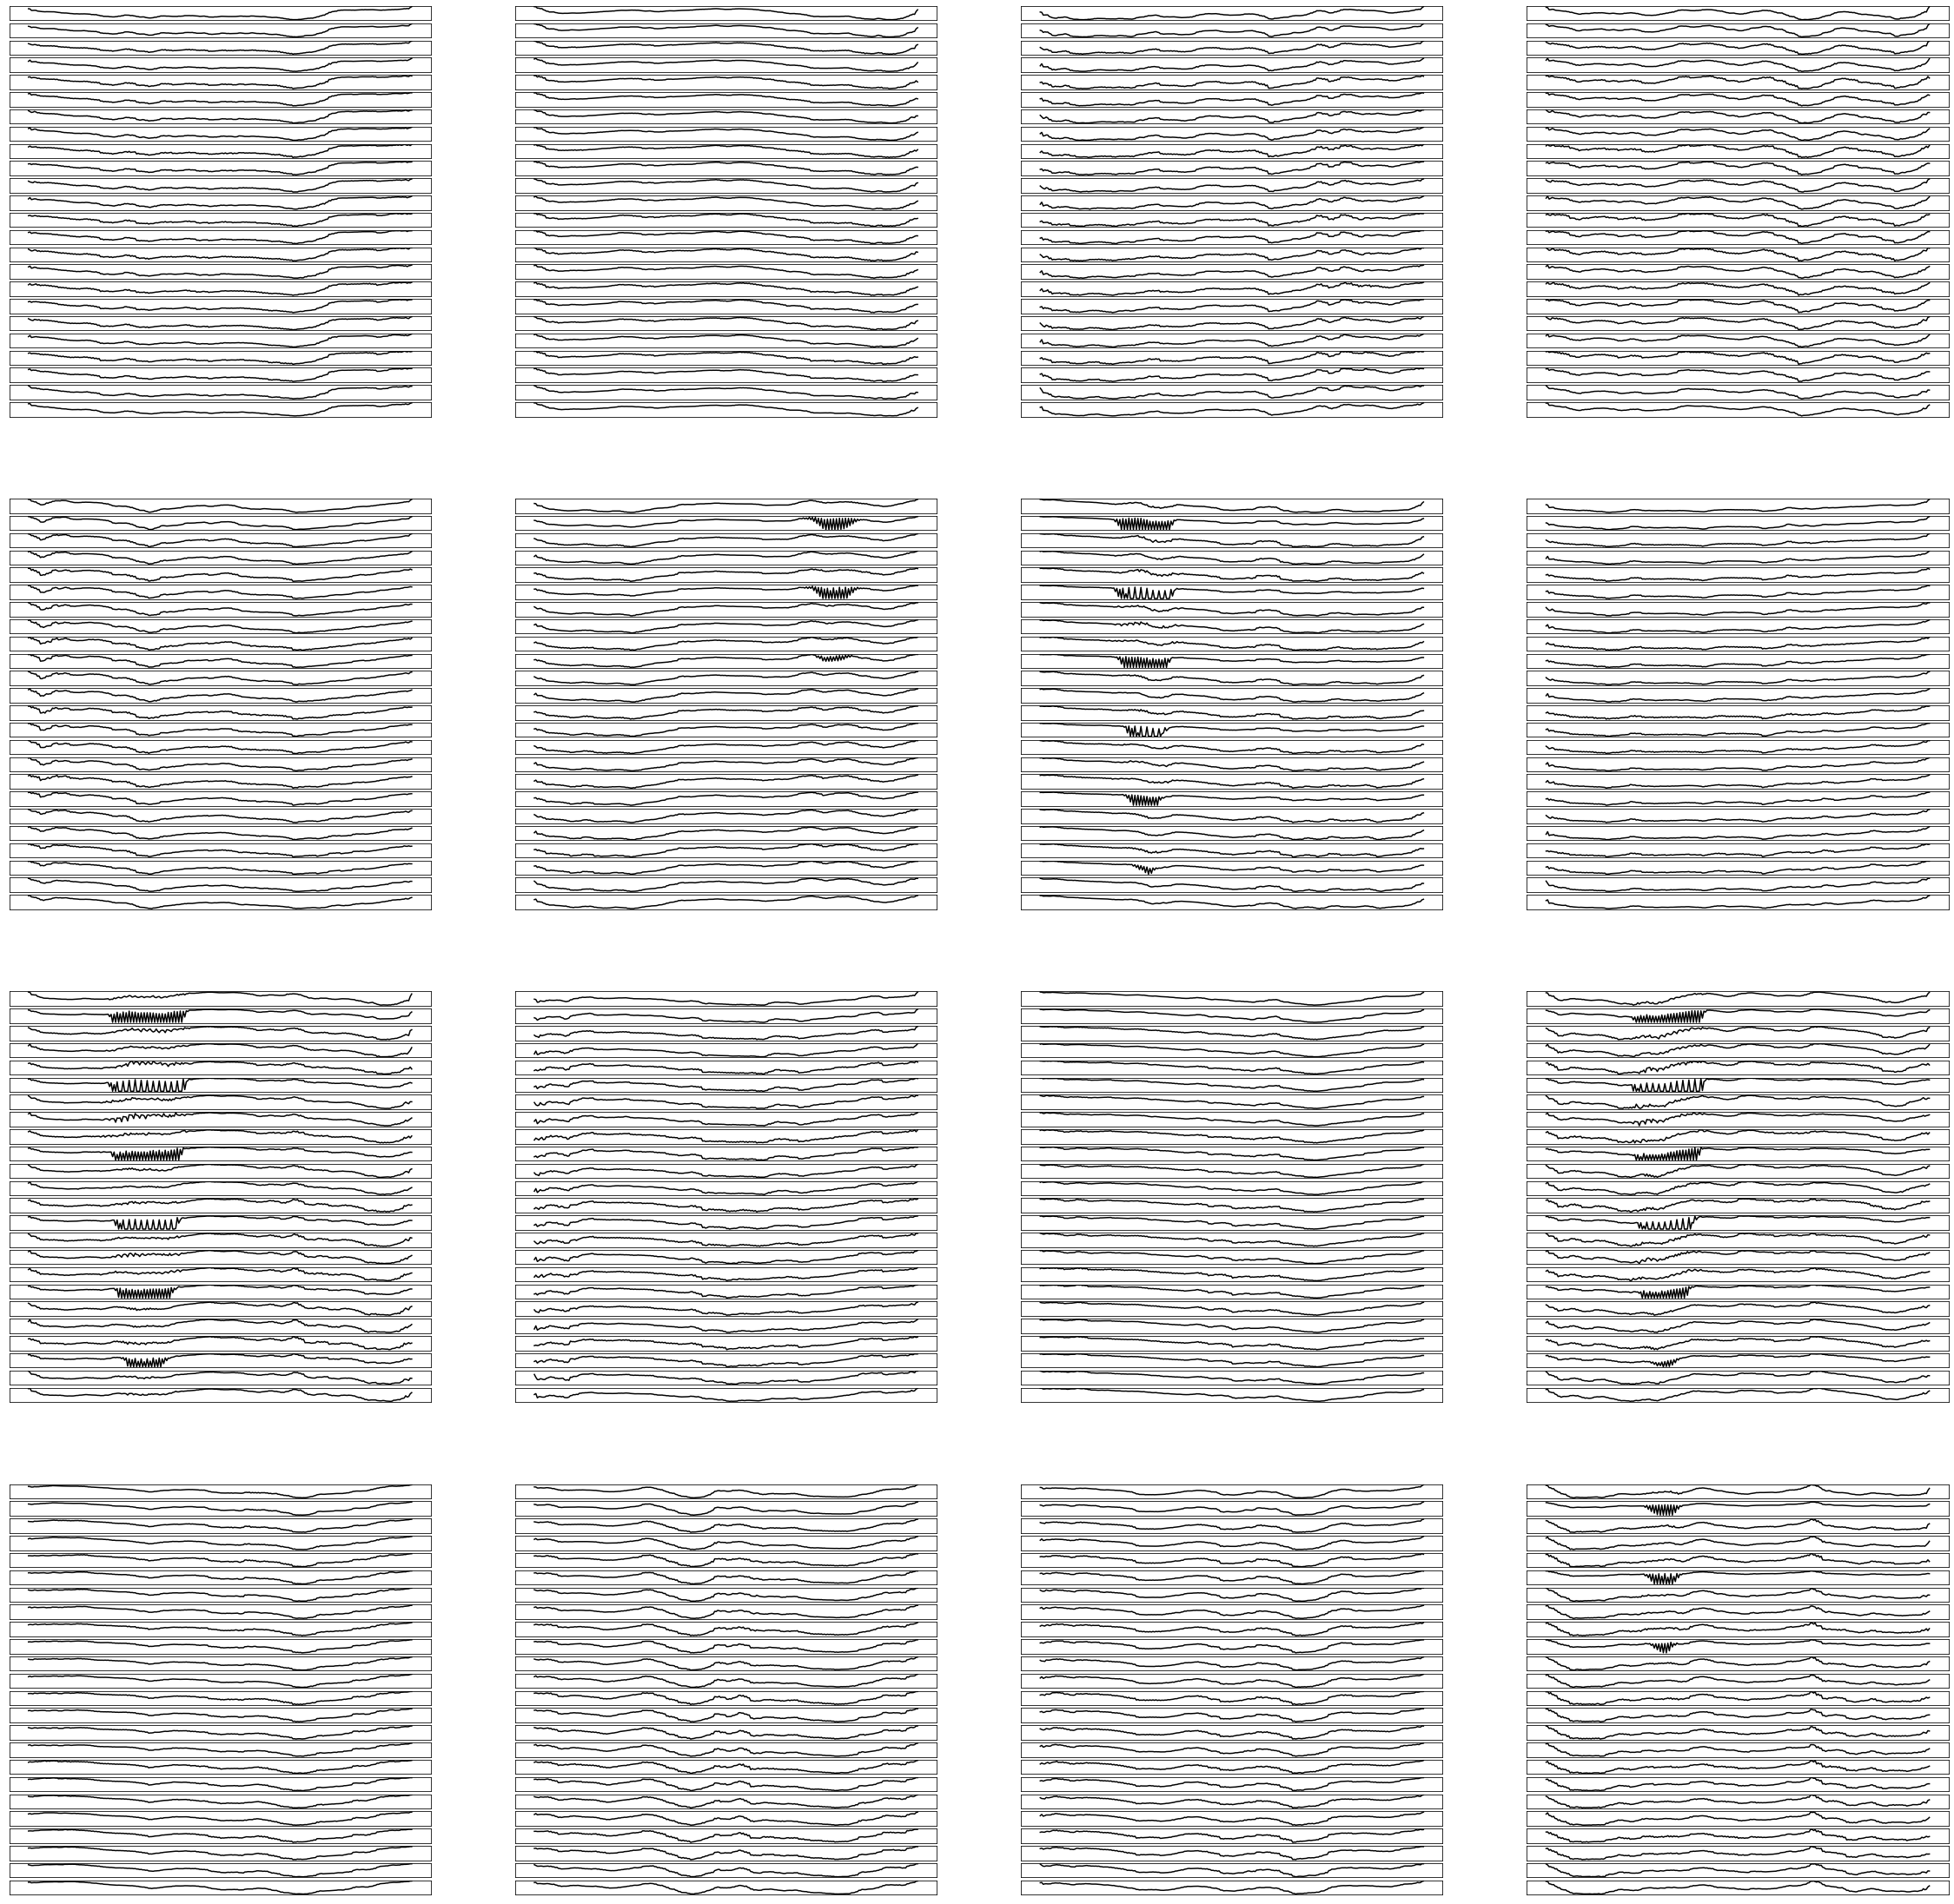

In [33]:
def plot_raw_sample(trained_model, train_data):
    trained_model.to(device='cpu')
    if isDebug:
    #     samples = trained_model.generate_sample(6).detach().numpy()
        ori_sample = mnist_train[9][0]
        plt.figure()
        plt.imshow(ori_sample[0,:,0:24].detach().numpy())
        samples, _, _ = trained_model(ori_sample.reshape((1,1,24,256)))
        samples = samples.detach().numpy()
        for s in range(samples.shape[0]):
            sample = samples[s,0,:,0:24].reshape(24,24)
            plt.figure()
            plt.imshow(sample)
    else:
        loader_test = enumerate(DataLoader(train_data, batch_size=len(train_data), shuffle=False))
        i,(x,y) = next(loader_test)
        plot_raw_EEG(x.detach().numpy(),16)
        x_hat,mu_hat,logvar_hat = trained_model(x)
        plot_raw_EEG(x_hat.detach().numpy(),16)
    return x, x_hat, mu_hat, logvar_hat
    #     plt.figure()

    #     samples = trained_model.generate_sample(16).detach().numpy()
    #     print(np.min(samples))
    #     print(np.max(samples))
    #     plot_raw_EEG(samples, 16)

x, x_hat, mu_hat, logvar_hat = plot_raw_sample(trained_model, train_data)

original data shape: torch.Size([20723, 24, 256])
reconstructed data shape: torch.Size([20723, 24, 256])


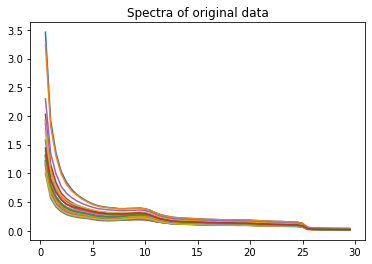

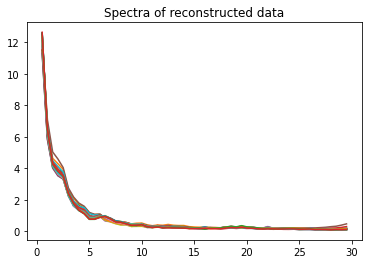

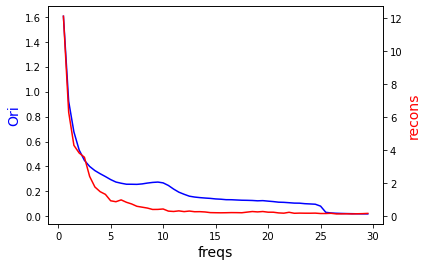

In [34]:
from scipy.fft import fft, ifft, fftfreq
def plot_spectra(x, x_hat):
    x = torch.squeeze(x,1) # remove uneeded dim
    print("original data shape:",x.shape)
    xf = fftfreq(256, 1/128)
    nfreqs = len(xf)
    spectra_ori = np.zeros((24,nfreqs))
    for iChan in range(24):
        x_chan = x[:,iChan,:]
        spectra_chan = np.zeros((x.shape[0], nfreqs))

        for iSample in range(x.shape[0]):
            sample = x_chan[iSample,:].detach().numpy()
            spectra_chan[iSample] = abs(fft(sample))
            
        spectra_ori[iChan,:] = np.mean(spectra_chan, axis=0)
        plt.plot(xf[1:60], spectra_ori[iChan,1:60], label=f'chan{iChan}')
#     plt.legend()
    plt.title('Spectra of original data')
    
    plt.figure()
    x_hat = torch.squeeze(x_hat,1) # remove uneeded dim
    print("reconstructed data shape:",x_hat.shape)
    spectra_recons = np.zeros((24,nfreqs))
    for iChan in range(24):
        x_chan = x_hat[:,iChan,:]
        spectra_chan = np.zeros((x.shape[0], nfreqs))

        for iSample in range(x.shape[0]):
            sample = x_chan[iSample,:].detach().numpy()
            spectra_chan[iSample] = abs(fft(sample))
            
        spectra_recons[iChan,:] = np.mean(spectra_chan, axis=0)
        plt.plot(xf[1:60], spectra_recons[iChan,1:60], label=f'chan{iChan}')
#     plt.legend()
    plt.title('Spectra of reconstructed data')

    # make a 2-axis plot
    fig,ax = plt.subplots()

    ax.plot(xf[1:60], np.mean(spectra_ori, axis=0)[1:60], label='mean original', color="blue")
    ax.set_xlabel("freqs", fontsize = 14)     # set x-axis label
    ax.set_ylabel("Ori", color='blue', fontsize=14)
    
    ax2=ax.twinx()
    ax2.plot(xf[1:60], np.mean(spectra_recons, axis=0)[1:60], label='mean reconstruct', color="red")    
    ax2.set_ylabel("recons", color='red', fontsize=14)
    plt.show()

plot_spectra(x, x_hat)

torch.Size([20723])
0.0007887392
(1, 1, 24, 256)
1
tensor([[[0.5221, 0.5196, 0.5181,  ..., 0.5220, 0.5224, 0.5239],
         [0.5258, 0.5222, 0.5199,  ..., 0.5447, 0.5448, 0.5455],
         [0.5250, 0.5238, 0.5228,  ..., 0.5239, 0.5240, 0.5246],
         ...,
         [0.5253, 0.5259, 0.5266,  ..., 0.5341, 0.5344, 0.5344],
         [0.5263, 0.5278, 0.5288,  ..., 0.5360, 0.5350, 0.5335],
         [0.5254, 0.5265, 0.5284,  ..., 0.5439, 0.5443, 0.5438]]])
1
[[[[0.5578846  0.5509721  0.49281663 ... 0.5764086  0.6314204
    0.6688653 ]
   [0.5229015  0.5119467  0.47629184 ... 0.5700294  0.62138855
    0.6466254 ]
   [0.5181972  0.49551815 0.48319796 ... 0.5691885  0.63274705
    0.6507335 ]
   ...
   [0.5088609  0.5215593  0.48260954 ... 0.5828176  0.5780045
    0.5779079 ]
   [0.58505386 0.540766   0.50160563 ... 0.5560748  0.5905175
    0.5889933 ]
   [0.5585631  0.57281816 0.49854642 ... 0.5719953  0.6100154
    0.62877125]]]]


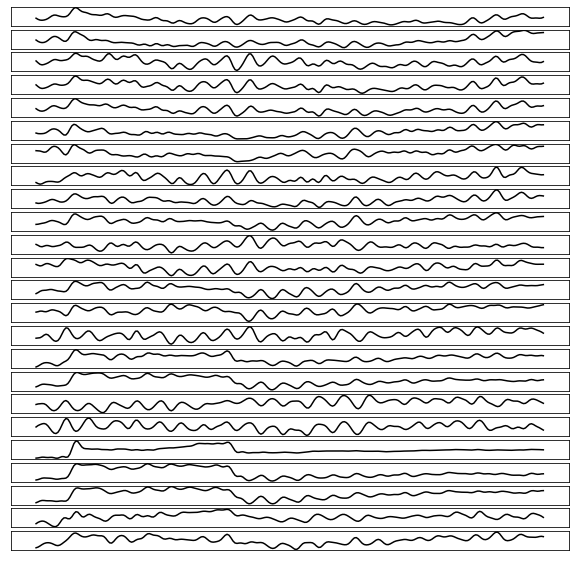

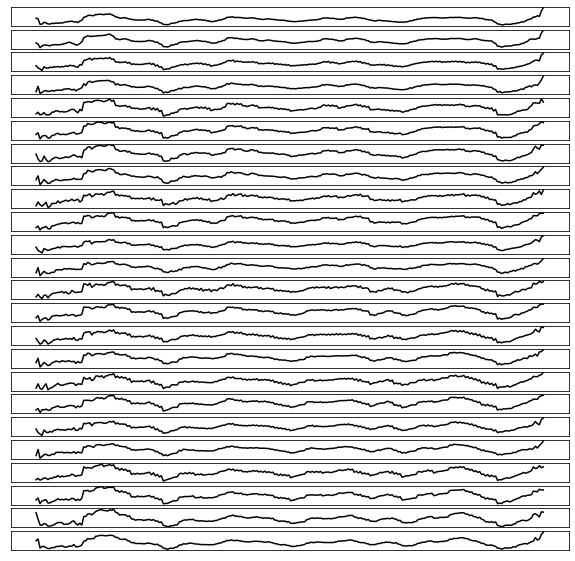

<Figure size 432x288 with 0 Axes>

In [35]:
def plot_best_recons(trained_model, x, x_hat, mu_hat, logvar_hat):
    loss_dict = trained_model.loss_function(x_hat, x, mu_hat, logvar_hat,M_N=1)
    loss = F.mse_loss(x_hat, x, reduction='none')
    loss = torch.squeeze(loss,1)
    loss = torch.reshape(loss,(-1, 24*256))
    loss = torch.mean(loss, axis=1)
    print(loss.shape)
    loss = loss.detach().numpy()
    min_loss_idx = np.argmin(loss)
    print(loss[min_loss_idx])
    min_loss_sample = np.reshape(x_hat[min_loss_idx].detach().numpy(), (1,1,24,256))
    print(min_loss_sample.shape)
#     plot_raw_EEG(torch.unsqueeze(x[0],0).detach().numpy(),min_loss_sample, 1) # issue with overlay
    plot_raw_EEG(torch.unsqueeze(x[min_loss_idx],0).detach().numpy(), 1)
    print(x[min_loss_idx])
    plot_raw_EEG(min_loss_sample,1)
    print(min_loss_sample)
    plt.figure()
plot_best_recons(trained_model, x, x_hat, mu_hat, logvar_hat)    

In [32]:
def check_var(log_var):
    plt.figure()
    var = log_var.exp()
    print("Var shape:",log_var.shape)
    n,bins,_=plt.hist(var.detach().numpy().flatten())
    plt.title('Variance')
    print("Var bins:",bins)
    print("Var bin counts:",n)    
check_var(sigma_hat)

def check_mu(mu):
    plt.figure()
    print("mu shape:",mu.shape)
    n, bins, _ = plt.hist(mu.detach().numpy().flatten())
    plt.title('Mu')
    print("mu bins:", bins)
    print("mu bin counts:",n)    
check_mu(mu_hat)

NameError: name 'sigma_hat' is not defined

In [38]:
def encode(model,x):
    for f in model.encoder_before_last:
        x = f(x)
    mu = model.encoder_mu(x)
    log_var = model.encoder_log_var(x)
    z = model.reparameterize(mu, log_var)
    return z

def save_latent(model, train_data, model):
    loader_test = enumerate(DataLoader(train_data, batch_size=len(train_data), shuffle=False))
    i,(x,y) = next(loader_test)
    z = encode(model,x)
    print(z.shape)
    z_numpy = np.reshape(z.detach().numpy(), (-1,10))
    np.save(f'{exp}/latent.npy',z_numpy)
    return z_numpy

latent = save_latent(trained_model, train_data, experiment)

SyntaxError: duplicate argument 'model' in function definition (<ipython-input-38-f4aca8647942>, line 12)

(20723, 10)
[0.32360297 0.13636929 0.09230082 0.08223063 0.08048437 0.06544074
 0.06097342 0.05473125 0.05222244 0.05164401]


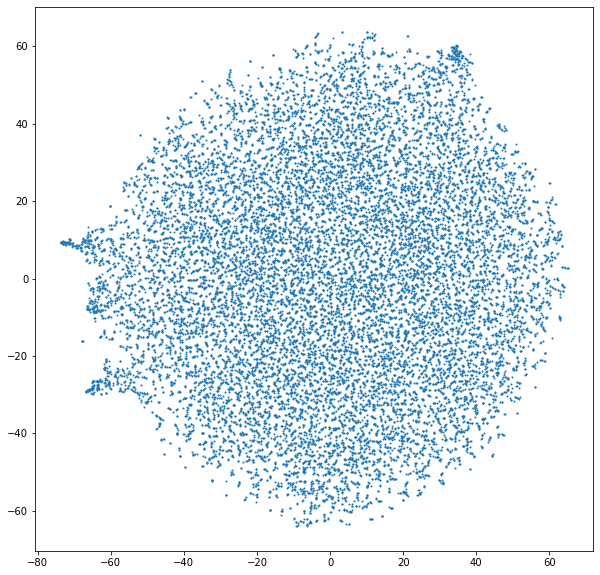

In [37]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA()
z_pca = pca.fit_transform(latent)
print(z_pca.shape)
print(pca.explained_variance_ratio_)

tsne = TSNE()
z_tsne = tsne.fit_transform(latent)
plt.figure(figsize=(10,10))
plt.scatter(z_tsne[:,0], z_tsne[:,1], s=1)
plt.show()

torch.Size([20723, 1, 24, 256])


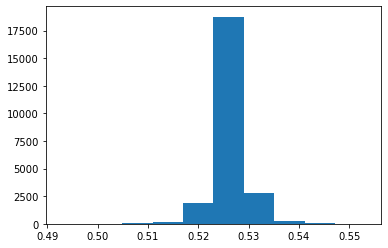

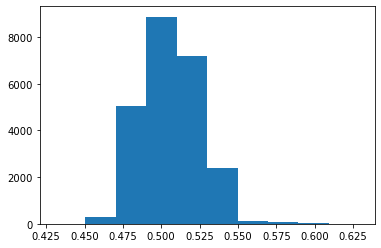

In [35]:
def check_likelihood(x,x_hat):
    x = x[:,0,:,:]
    x_reshaped = torch.transpose(x, 1,0)
    x_reshaped = torch.reshape(x_reshaped, (24, -1))
    plt.hist(x_reshaped[:,0:1000].detach().numpy().flatten())
    
    plt.figure()
    print(x_hat.shape)
    x_hat = x_hat[:,0,:,:]
    x_hat_reshaped = torch.transpose(x_hat, 1,0)
    x_hat_reshaped = torch.reshape(x_hat_reshaped, (24, -1))
    plt.hist(x_hat_reshaped[:,0:1000].detach().numpy().flatten())
check_likelihood(x,x_hat)

(array([1232., 6420., 6649., 4092., 1193.,  318.,  173.,  199.,  179.,
         268.]),
 array([-2.0898519,  5.408434 , 12.906719 , 20.405005 , 27.903292 ,
        35.401577 , 42.899864 , 50.398148 , 57.896435 , 65.39472  ,
        72.893005 ], dtype=float32),
 <BarContainer object of 10 artists>)

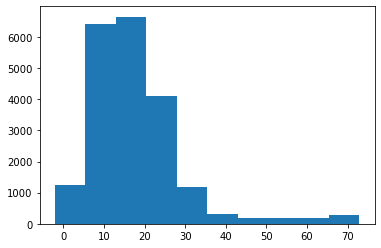

In [156]:
plt.hist(latent[:,6])

In [136]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

mlp = MLPClassifier(alpha=1, max_iter=1000)
svc_kernel = SVC(kernel="linear", C=0.025)
svc_gamma = SVC(gamma=2, C=1)
random_forest = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
lda = LinearDiscriminantAnalysis()
logistic = LogisticRegression()
trained_model.to('cpu')

# data_train = torch.tensor(X_train)
# data_train = encode(trained_model,data_train).cpu().detach().numpy()
# print('train data shape:', data_train.shape)
# label_train = np.squeeze(Y_train,axis=1)

data_val = torch.tensor(X_val)
data_val = encode(trained_model,data_val).cpu().detach().numpy()
print('val data shape:', data_val.shape)
label_val = np.squeeze(Y_val,axis=1)

mlp.fit(data_train, label_train)
print("MLP score:",mlp.score(data_val, label_val))
svc_kernel.fit(data_train, label_train)
print("SVC kernel score:",svc_kernel.score(data_val, label_val))
# svc_gamma.fit(data_train, label_train)
# print("SVC gamma score:",svc_gamma.score(data_val, label_val))
lda.fit(data_train, label_train)
print("LDA score:",lda.score(data_val, label_val))
logistic.fit(data_train, label_train)
print("Logistic regression score:",logistic.score(data_val, label_val))
random_forest.fit(data_train, label_train)
print("RFscore:",random_forest.score(data_val, label_val))


(array([  39398.,   88022.,  352421., 1210464., 1558149., 1331032.,
         519120.,  143383.,   56661.,    6438.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

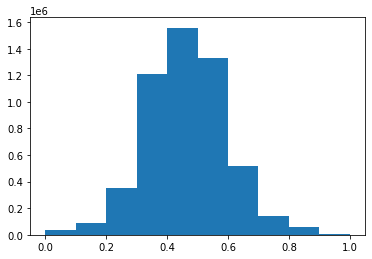

In [49]:
plt.hist(x.detach().numpy()[:,0,2,:].flatten())

(array([  12062.,  168483.,  326666.,   99799.,  738046.,  418897.,
        1810573., 1438260.,  279578.,   12724.]),
 array([0.40411696, 0.41418225, 0.42424753, 0.43431282, 0.4443781 ,
        0.4544434 , 0.46450865, 0.47457394, 0.48463923, 0.4947045 ,
        0.5047698 ], dtype=float32),
 <BarContainer object of 10 artists>)

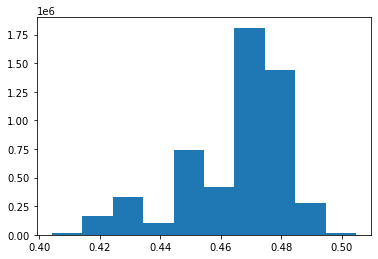

In [50]:
plt.hist(x_hat.detach().numpy()[:,0,1,:].flatten())